In [2]:
import sys
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/poc")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/dags")

#Import libs python
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import date

#Import libs internas
from utils import spark_utils_session as utils

from hooks.hdfs.hdfs_helper import HdfsHelper
from jobs.job_base_config import BaseETLJobClass

import poc_helper
poc_helper.load_env("PROD")

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/airflow_metastore_helper.py:10 DeprecatedImportWarning: The `airflow.utils.xcom.XCOM_RETURN_KEY` attribute is deprecated. Please use `'airflow.models.xcom.XCOM_RETURN_KEY'`.

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/impala_helper.py:6 DeprecatedImportWarning: The `airflow.hooks.base.BaseHook` attribute is deprecated. Please use `'airflow.sdk.bases.hook.BaseHook'`.

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/postgres_helper.py:4 DeprecatedImportWarning: The `airflow.hooks.base.BaseHook` attribute is deprecated. Please use `'airflow.sdk.bases.hook.BaseHook'`.

'.env_file' loaded!
ENV 'PROD' configured!


In [3]:
def get_session(profile: str, dynamic_allocation_enabled: bool = True) -> utils.DBASparkAppSession:
    """Generates DBASparkAppSession."""
    
    app_name = "tsevero_geiG"
    
    spark_builder = (utils.DBASparkAppSession
                     .builder
                     .setAppName(app_name)
                     .usingProcessProfile(profile)
                    )
    
    if dynamic_allocation_enabled:
        spark_builder.autoResourceManagement()

    return spark_builder.build()

session = get_session(profile='efd_t2')

2025-10-01T17:47:27.704785Z [info     ] Using json file settings.      [root] loc=spark_utils_session.py:301
2025-10-01T17:47:27.706196Z [info     ] Exporting default ENV.         [root] loc=spark_utils_session.py:305
2025-10-01T17:47:27.706740Z [info     ] Exporting custom ENVs.         [root] loc=spark_utils_session.py:338
2025-10-01T17:47:27.707284Z [info     ] Building profile 'efd_t2'.     [root] loc=spark_utils_session.py:221
2025-10-01T17:47:27.707680Z [info     ] Not enough info for building the kerberos client. Ignoring it [root] loc=spark_utils_session.py:284


:: loading settings :: url = jar:file:/opt/cloudera/parcels/SPARK3-3.5.4.3.5.7191000.0-30-1.p0.68499982/lib/spark3/jars/ivy-2.5.2.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/tsevero/.ivy2/cache
The jars for the packages stored in: /home/tsevero/.ivy2/jars
com.databricks#spark-xml_2.12 added as a dependency
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
com.oracle.database.security#oraclepki added as a dependency
com.oracle.database.security#osdt_core added as a dependency
com.oracle.database.security#osdt_cert added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4b3ad410-6331-4d80-a473-a4fb8a636f06;1.0
	confs: [default]
	found com.databricks#spark-xml_2.12;0.18.0 in central
	found commons-io#commons-io;2.11.0 in central
	found org.glassfish.jaxb#txw2;3.0.2 in central
	found org.apache.ws.xmlschema#xmlschema-core;2.3.0 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.9.0 in central
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.9.2 in central
	found com.oracle.database.security#oraclepki;21.18.0.0 in central
	found com.oracle.databa

In [4]:
session.sparkSession.sql("SHOW DATABASES").show(truncate=False)

Hive Session ID = 12d771a7-0fe4-4c58-b1e9-7401891aae12


+------------------+
|namespace         |
+------------------+
|anac              |
|bcadastro         |
|bpe               |
|c115              |
|ccc               |
|ccg               |
|cte               |
|default           |
|destda            |
|detran_share      |
|dime              |
|due               |
|efd               |
|fci               |
|gecob             |
|gescol            |
|gessimples        |
|gplam             |
|information_schema|
|malhas            |
+------------------+
only showing top 20 rows



In [6]:
# =============================================================================
# CÉLULA 1: CONFIGURAÇÃO DO AMBIENTE E INICIALIZAÇÃO DO SPARK
# =============================================================================

# Importação de bibliotecas para visualização e manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Configurações Visuais e de Ambiente ---
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 12

print("="*60)
print("SISTEMA DE ANÁLISE DE DADOS - GEI (Gestão de Empresas e Indícios)")
print("="*60)

# --- Verificação da Sessão Spark ---
try:
    if 'session' in locals() and session.sparkSession:
        spark = session.sparkSession
        print(f"✅ Sessão Spark ('{spark.sparkContext.appName}') ativa e pronta para uso.")
    else:
        raise NameError("A variável 'session' do Spark não foi encontrada ou inicializada.")
except Exception as e:
    print(f"❌ ERRO CRÍTICO: {e}")
    print("Por favor, execute a célula de configuração inicial que define a 'session' antes de prosseguir.")
    # Em um ambiente de notebook, não usamos exit(). Apenas alertamos o usuário.

SISTEMA DE ANÁLISE DE DADOS - GEI (Gestão de Empresas e Indícios)
✅ Sessão Spark ('tsevero_geiG') ativa e pronta para uso.


In [7]:
# =============================================================================
# CÉLULA 2: CARREGAMENTO E ANÁLISE PRELIMINAR DOS DADOS
# =============================================================================

try:
    print("🔄 Carregando a tabela principal 'gessimples.gei_percent'...")
    
    # Carrega a tabela para um DataFrame Spark
    df_percent = spark.table("gessimples.gei_percent")
    
    # Armazena o DataFrame em cache para otimizar consultas futuras
    df_percent.cache()
    
    total_grupos = df_percent.count()
    print(f"✅ Tabela carregada com sucesso: {total_grupos:,} grupos encontrados.")
    
    print("\nAmostra dos dados (primeiras 5 linhas):")
    df_percent.show(5, truncate=False)
    
    print("\nSchema da tabela (colunas e tipos de dados):")
    df_percent.printSchema()

except Exception as e:
    print(f"❌ ERRO ao carregar a tabela 'gessimples.gei_percent'.")
    print(f"   Verifique se a tabela existe e se o nome está correto.")
    print(f"   Detalhes: {e}")

🔄 Carregando a tabela principal 'gessimples.gei_percent'...


✅ Tabela carregada com sucesso: 3,233 grupos encontrados.

Amostra dos dados (primeiras 5 linhas):
+---------+---------+------------+----------+-------------+-------------+-------------------+---------------+-------------+-------------+----------------------+-------------------+-----+------------+-----------+---------------+-----------+-------+-----------+--------+------+-----------+-------+--------------+-------+-----------+-----------+-------------------------+----------------------+-----------------------------------+----------------------------+---------------------+-------------------+-------------+----------------------+-----------------------+--------------------------------+--------------------------------+--------------------------+----------------------------------+---------------------------+---------------+------------------------------+-----------------------------------------+-----------------------+-----------------------------------+----------------------------+--------

📊 Análise do Score de Risco Final ('score_final_avancado')...


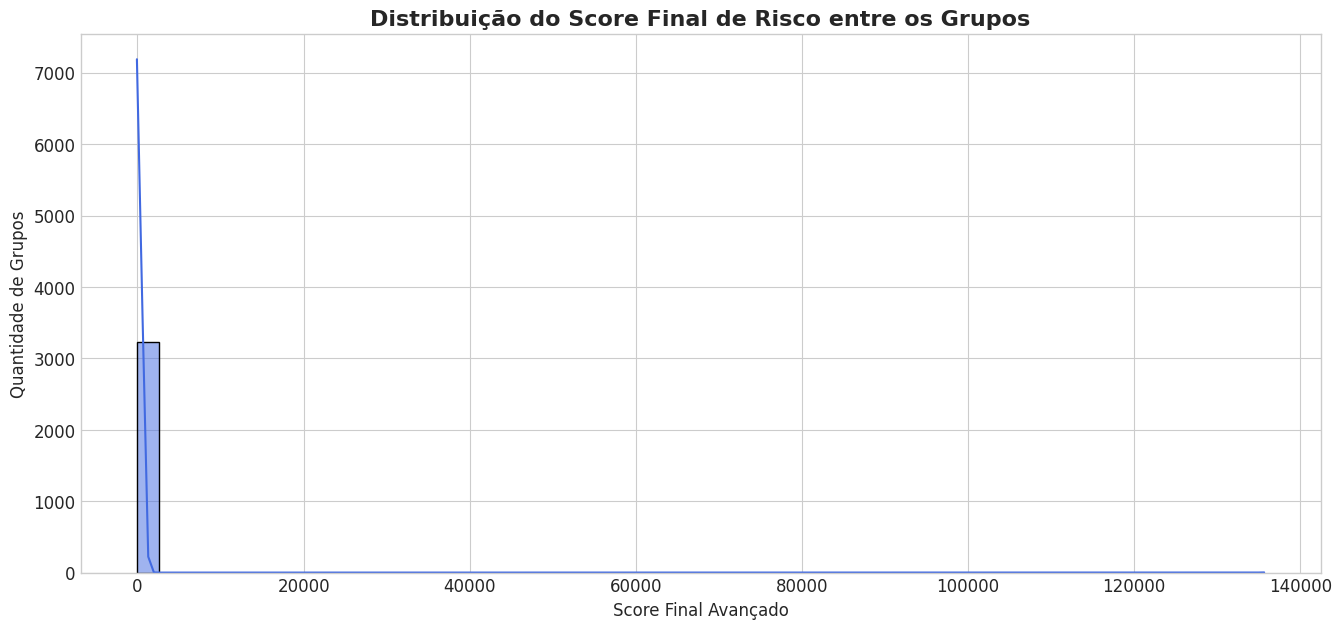


🏆 Top 20 Grupos por Score Final de Risco:


2025-10-01T17:49:50.546602Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224
2025-10-01T17:49:50.551545Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224


+---------+--------------------+---------+-------------------+----------------------------+-----------------------+
|num_grupo|score_final_avancado|qntd_cnpj|indice_interconexao|indice_risco_grupo_economico|indice_risco_pagamentos|
+---------+--------------------+---------+-------------------+----------------------------+-----------------------+
|3574     |135647.16           |2        |1.00               |0.0000                      |904045.4500            |
|9433     |95.72               |3        |1.00               |66.6700                     |0.0000                 |
|2968     |92.19               |34       |0.30               |4.1000                      |0.0000                 |
|15908    |89.87               |3        |0.67               |66.6700                     |0.0000                 |
|12000    |89.22               |2        |1.00               |50.0000                     |0.0000                 |
|3777     |86.77               |3        |0.33               |66.6700   

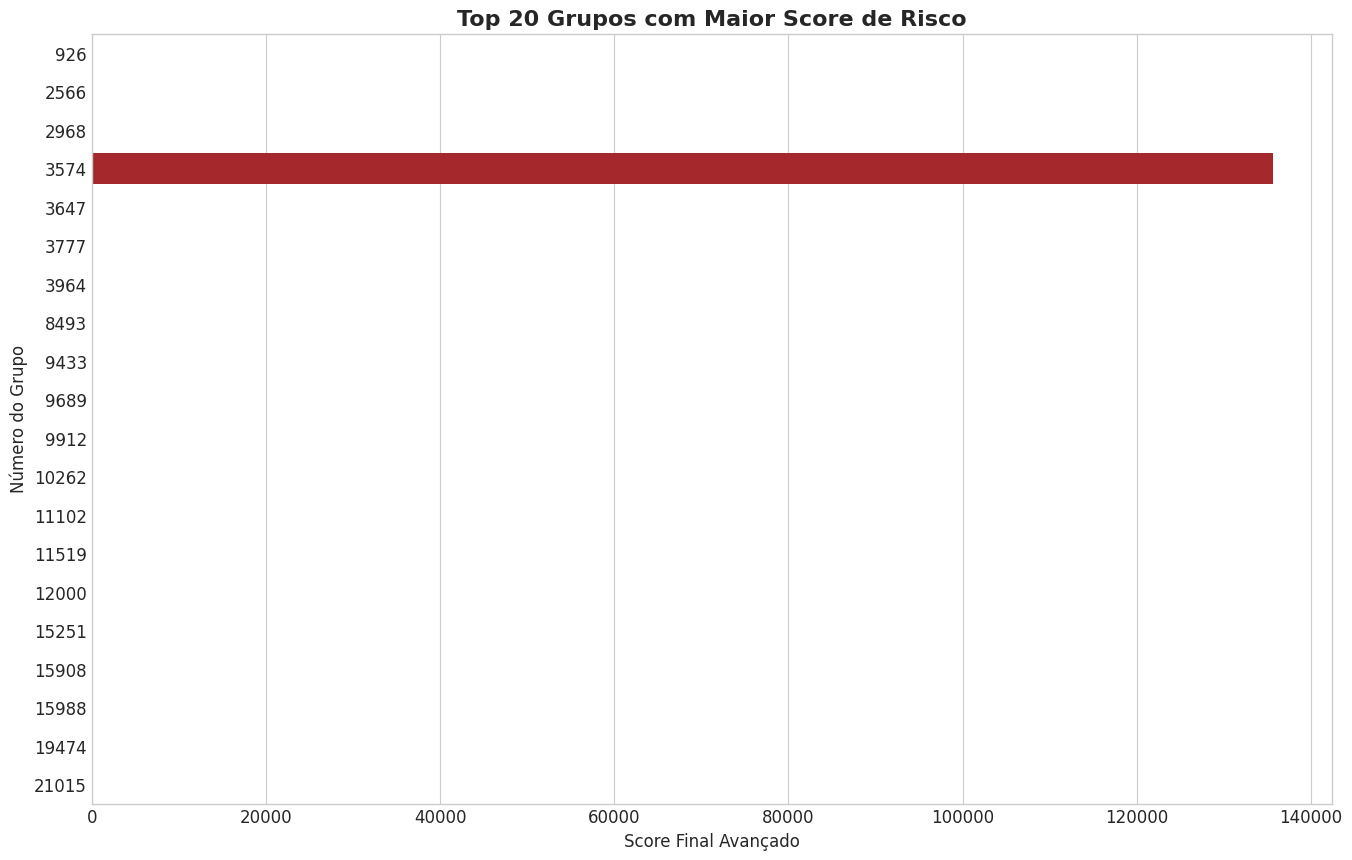

In [8]:
# =============================================================================
# CÉLULA 3: VISÃO GERAL E DISTRIBUIÇÃO DO RISCO
# =============================================================================

print("📊 Análise do Score de Risco Final ('score_final_avancado')...")

# Seleciona apenas a coluna do score para análise e remove valores nulos
score_data = df_percent.select("score_final_avancado").dropna().toPandas()

# Gráfico 1: Histograma da Distribuição do Score
plt.figure(figsize=(16, 7))
sns.histplot(score_data['score_final_avancado'], kde=True, bins=50, color='royalblue')
plt.title('Distribuição do Score Final de Risco entre os Grupos', fontsize=16, fontweight='bold')
plt.xlabel('Score Final Avançado')
plt.ylabel('Quantidade de Grupos')
plt.show()

# --- Top 20 Grupos por Score de Risco ---
print("\n🏆 Top 20 Grupos por Score Final de Risco:")
top_20_risco = df_percent.select(
    "num_grupo",
    "score_final_avancado",
    "qntd_cnpj",
    "indice_interconexao",
    "indice_risco_grupo_economico",
    "indice_risco_pagamentos"
).orderBy(desc("score_final_avancado"))

top_20_risco.show(20, truncate=False)

# Gráfico 2: Gráfico de barras dos Top 20 grupos
top_20_pd = top_20_risco.limit(20).toPandas()

plt.figure(figsize=(16, 10))
sns.barplot(data=top_20_pd, y='num_grupo', x='score_final_avancado', palette='Reds_r', orient='h')
plt.title('Top 20 Grupos com Maior Score de Risco', fontsize=16, fontweight='bold')
plt.xlabel('Score Final Avançado')
plt.ylabel('Número do Grupo')
plt.yticks(rotation=0)
plt.show()

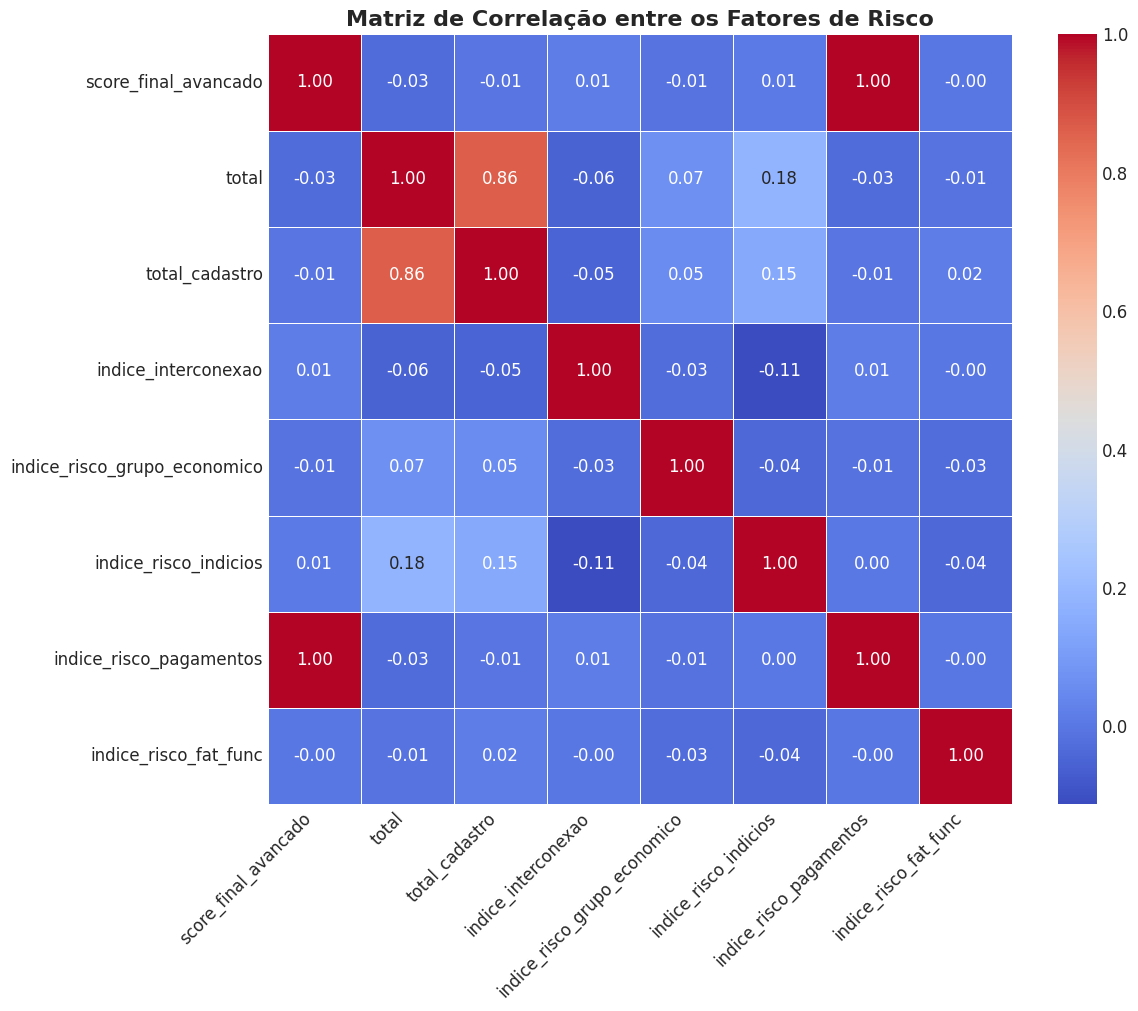

In [9]:
# =============================================================================
# CÉLULA 4: ANÁLISE DOS PRINCIPAIS FATORES DE RISCO
# =============================================================================

# Seleciona as colunas de risco para a matriz de correlação
fatores_risco_cols = [
    "score_final_avancado",
    "total",  # Inconsistências NFe
    "total_cadastro", # Consistência Cadastral
    "indice_interconexao", # Risco Societário
    "indice_risco_grupo_economico", # Risco C115
    "indice_risco_indicios",
    "indice_risco_pagamentos",
    "indice_risco_fat_func" # Faturamento vs Funcionários
]

# Amostra dos dados para performance e conversão para Pandas
df_sample = df_percent.select(fatores_risco_cols).dropna().sample(False, 0.5).limit(5000)
df_fatores_pd = df_sample.toPandas()

# Calcula a matriz de correlação
correlation_matrix = df_fatores_pd.corr()

# Gráfico: Heatmap da Correlação entre Fatores de Risco
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlação entre os Fatores de Risco', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

🔄 Realizando análise de risco por setor econômico (CNAE)...

📊 Top 15 Setores por Score de Risco Médio (com mais de 10 grupos):


+----------+-----------------+-----------------+
|secao_cnae|quantidade_grupos|score_medio_setor|
+----------+-----------------+-----------------+
|47        |3619             |77.692802        |
|15        |28               |61.324286        |
|26        |19               |59.086316        |
|16        |87               |53.941379        |
|22        |94               |52.831277        |
|28        |93               |52.120753        |
|14        |267              |52.119813        |
|13        |70               |51.938571        |
|20        |13               |51.439231        |
|17        |34               |50.125294        |
|46        |379              |49.609472        |
|77        |10               |48.963000        |
|81        |21               |48.799524        |
|25        |125              |47.825120        |
|38        |13               |45.853846        |
+----------+-----------------+-----------------+
only showing top 15 rows



2025-10-01T17:50:30.478220Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224
2025-10-01T17:50:30.483045Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224


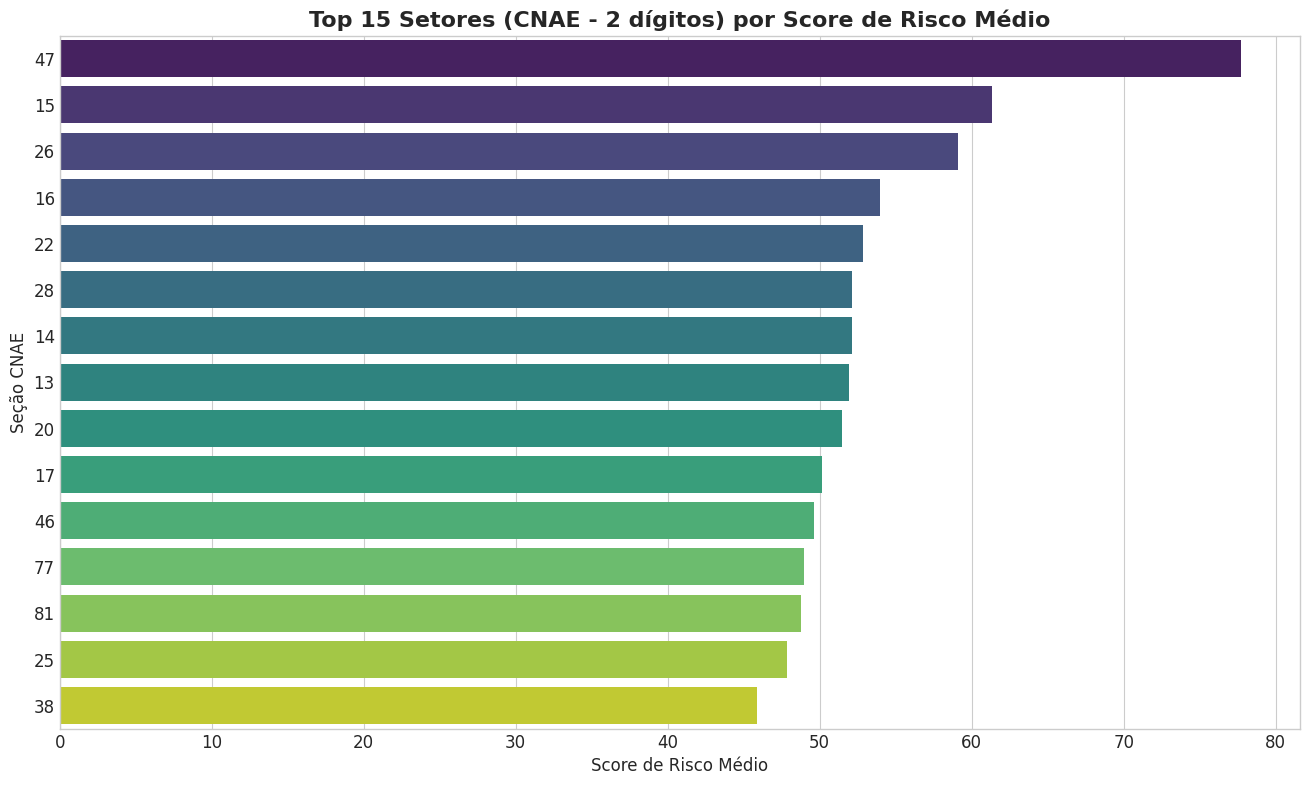

In [10]:
# =============================================================================
# CÉLULA 5: ANÁLISE SETORIAL POR CNAE
# =============================================================================
print("🔄 Realizando análise de risco por setor econômico (CNAE)...")

try:
    # Query para juntar os dados de score com os dados cadastrais (CNAE)
    query_setor = """
    SELECT
        SUBSTRING(CAST(cad.cd_cnae AS STRING), 1, 2) AS secao_cnae,
        p.score_final_avancado
    FROM
        gessimples.gei_percent p
    JOIN gessimples.gei_cnpj c ON p.num_grupo = c.num_grupo
    JOIN gessimples.gei_cadastro cad ON c.cnpj = cad.nu_cnpj
    WHERE cad.cd_cnae IS NOT NULL
    """
    df_setor = spark.sql(query_setor)

    # Agrega os dados por setor para calcular a média de risco
    analise_setorial = df_setor.groupBy("secao_cnae") \
        .agg(
            count("score_final_avancado").alias("quantidade_grupos"),
            avg("score_final_avancado").alias("score_medio_setor")
        ) \
        .filter("quantidade_grupos >= 10") \
        .orderBy(desc("score_medio_setor"))

    print("\n📊 Top 15 Setores por Score de Risco Médio (com mais de 10 grupos):")
    analise_setorial.show(15, truncate=False)

    # Gráfico: Barplot dos setores mais críticos
    setorial_pd = analise_setorial.limit(15).toPandas()

    plt.figure(figsize=(16, 9))
    sns.barplot(data=setorial_pd, y='secao_cnae', x='score_medio_setor', palette='viridis', orient='h')
    plt.title('Top 15 Setores (CNAE - 2 dígitos) por Score de Risco Médio', fontsize=16, fontweight='bold')
    plt.xlabel('Score de Risco Médio')
    plt.ylabel('Seção CNAE')
    plt.show()

except Exception as e:
    print(f"❌ ERRO na análise setorial. Verifique se as tabelas 'gei_cnpj' e 'gei_cadastro' existem.")
    print(f"   Detalhes: {e}")